In [31]:
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB import PDBList
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

In [3]:
pdbid = '2q4g'
chain = 'Y'
repeats = "2-30,31-58,59-87,88-115,116-144,145-172,173-201,202-229,230-258,259-286,287-315,316-343,344-372,373-400,401-429,430-455"
repeats = repeats.split(',')
repeats = [[int(idx.split('-')[0]), int(idx.split('-')[1])] for idx in repeats]
path = '/home/bio'
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdbid, pdir=path, file_format='pdb')
structure = PDBParser(QUIET=True).get_structure(pdbid, path + "/pdb/{}.pdb".format(pdbid))

In [4]:
selected_chain = structure[0][chain]
selected_residues = [res for res in selected_chain if res.id[0] == " "] # Exclude hetero groups and solvent
#selected_atoms = [atom for residue in selected_residues for atom in residue.get_atoms()]

In [5]:
sup = SVDSuperimposer()


In [6]:
CA_pos = []
for res in selected_residues:
    CA_pos.append(list(res['CA'].get_vector()))
CA_pos = np.array(CA_pos)
CA_pos

array([[40.02899933, 66.65399933, -7.58500004],
       [40.98899841, 66.28099823, -3.92400002],
       [41.83599854, 68.98300171, -1.38300002],
       ...,
       [70.87000275, 64.84100342, 18.00399971],
       [67.98200226, 64.83899689, 20.47200012],
       [68.51300049, 66.33499908, 23.92399979]])

Basic proof of concept for getting the translation matricies that super-imposes one unit onto the next.\
TODO: Probably explore using vinilla SVD from scipy to get all of the principal vectors so the torsion angles can be calculated according to this paper;
https://onlinelibrary.wiley.com/doi/10.1002/jcc.20237 \
also SVD could be unstable if two principal directions have similar magnitude leading to axes being permutated. this would need to be investigated if this is actually a problem, or if another method of getting unit orientation needs to be worked out.
more info on calculating torsion angles;
https://www.youtube.com/watch?v=NSU0OnW9yLk \ 

here is  blog detailing the re-implementation of the SVD-superimposer (very simple)

https://ideasbyjin.github.io/post/2019-10-06-rmsd/


In [37]:
def get_rot_tran(coord_true, coord_pred):
    """
    Given two matrices, return a rotation and translation matrix to move
    pred coords onto true coords.
    Largely based on SVDSuperimposer implementation from BioPython with some tweaks.
    """
    centroid_pred = np.sum(coord_pred, axis=0) / coord_pred.shape[0]
    centroid_true = np.sum(coord_true, axis=0) / coord_true.shape[0]
    
    p_prime = coord_pred - centroid_pred
    q_prime = coord_true - centroid_true
    
    W = np.dot(q_prime.T, p_prime)
    U, S, Vt = np.linalg.svd(W)
    
    V = Vt.T
    
    rot = np.dot(V, U.T)
    det = np.linalg.det(rot)
    
    # The determinant is needed to detect whether we need a right-hand coordinate system or not
    # This basically means we just have to flip the Z-axis
    if det < 0:
        Vt[:,2] = -Vt[:,2]
        V = Vt.T
        rot = np.dot(V, U.T)
        
    tran = centroid_true - np.dot(centroid_pred, rot)
    return W, U, V

In [38]:
len(repeats)

16

In [64]:
Vt_hist = []
for i in range(len(repeats) - 1):
    unit = CA_pos[repeats[i][0]:repeats[i][1]+1,:]
    U, S, V = np.linalg.svd(unit)
    Vt_hist.append(V.T)
    print(F"{S} -- {V.T}")
Vt_hist

[474.16867855  32.3833624   24.46880987] -- [[-0.49095808  0.20849532 -0.84586634]
 [-0.858365   -0.28171375  0.42877369]
 [-0.14889487  0.93657197  0.31727473]]
[435.8056346   33.96607976  29.20339418] -- [[-0.43996192  0.37457199  0.81616747]
 [-0.87487513 -0.38377981 -0.29547683]
 [-0.20255126  0.84404317 -0.49655222]]
[412.73667456  35.11003883  28.94768798] -- [[-0.42527292  0.23054915  0.87520857]
 [-0.86940369 -0.37283523 -0.32423929]
 [-0.2515555   0.89879974 -0.35899701]]
[378.6361637   34.36558508  23.09492641] -- [[-0.43117515  0.55952934 -0.70782407]
 [-0.84134219  0.03405527  0.53942892]
 [-0.32593144 -0.8281106  -0.45607185]]
[362.22041521  33.33471549  20.92428104] -- [[-0.45878951  0.41875748 -0.78368001]
 [-0.80150688  0.18566121  0.5684335 ]
 [-0.38353476 -0.88891624 -0.25045759]]
[339.94120517  34.1719626   10.10115962] -- [[-0.52877727  0.40599352  0.74536157]
 [-0.73554777  0.218996   -0.6411008 ]
 [-0.42351397 -0.88724856  0.18282752]]
[340.07687847  35.6361316   

[array([[-0.49095808,  0.20849532, -0.84586634],
        [-0.858365  , -0.28171375,  0.42877369],
        [-0.14889487,  0.93657197,  0.31727473]]),
 array([[-0.43996192,  0.37457199,  0.81616747],
        [-0.87487513, -0.38377981, -0.29547683],
        [-0.20255126,  0.84404317, -0.49655222]]),
 array([[-0.42527292,  0.23054915,  0.87520857],
        [-0.86940369, -0.37283523, -0.32423929],
        [-0.2515555 ,  0.89879974, -0.35899701]]),
 array([[-0.43117515,  0.55952934, -0.70782407],
        [-0.84134219,  0.03405527,  0.53942892],
        [-0.32593144, -0.8281106 , -0.45607185]]),
 array([[-0.45878951,  0.41875748, -0.78368001],
        [-0.80150688,  0.18566121,  0.5684335 ],
        [-0.38353476, -0.88891624, -0.25045759]]),
 array([[-0.52877727,  0.40599352,  0.74536157],
        [-0.73554777,  0.218996  , -0.6411008 ],
        [-0.42351397, -0.88724856,  0.18282752]]),
 array([[-0.60147855, -0.32883367,  0.72807415],
        [-0.66333908, -0.30230883, -0.6845368 ],
        

In [57]:
S

array([542.38657649,  43.16476539,  11.81983748])

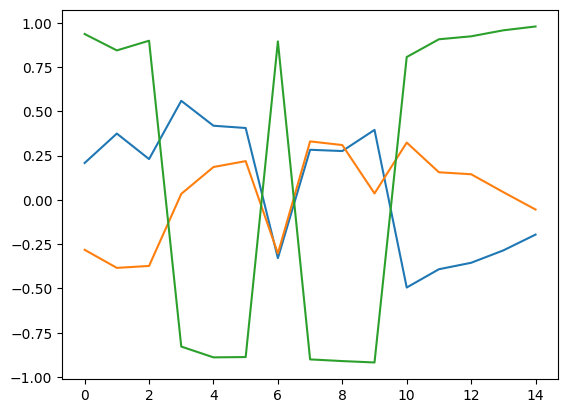

In [52]:
hist = np.array(Vt_hist)
plt.plot(hist[:, 0])
plt.plot(hist[:, 1])
plt.plot(hist[:, 2])

In [71]:
def compute_angles(mats):
    angles = []
    for i in range(1, len(mats)):
        m1 = mats[i-1]
        m2 = mats[i]
        #v1 = vectors[i-1]
        #v2 = vectors[i]
        #cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
        #angle = np.arccos(np.clip(cos_angle, -1, 1))  # avoid floating point errors
        #angles.append(np.degrees(angle))
        rel_rot_mat = np.dot(m1.T,m2)
        euler = Rotation.from_matrix(rel_rot_mat).as_euler('xyz', degrees=True)
        '''
        torsion = []
        for j in range(3):
            v1 = rel_rot_mat[:,j]
            v2 = rel_rot_mat[:,j]
            theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            torsion.append(theta)
        '''
        print(euler)
        #angles.append(torsion)
    return angles
compute_angles(Vt_hist)

[-0.10235919 -0.34121453 -3.14104675]
[-8.51447806 -1.98885876 -2.17675026]
[129.10312126  -0.7125726   -4.51259455]
[12.10063695 -3.85924875  1.93030821]
[-0.11788465 -0.0316004   2.29075816]
[-1.79930751e+02  7.36025188e-02  1.31023792e+00]
[-1.79908759e+02 -4.41409608e-02  1.64259729e+00]
[ 0.63589261  5.39216143 -1.15711106]
[16.85168237  3.46067614 -2.33542182]
[-157.76707596    1.24630128   -2.9505254 ]
[-12.49359907   1.62514325   1.89868605]
[-1.66868946  1.88990833  1.63813475]
[-7.27160457  3.05786733  0.49129544]
[-7.60791323  3.47807743  0.86671382]


[]

In [33]:
for i in range(len(repeats) - 1):
    print(f"start: {repeats[i][0]} end: {repeats[i][1]}")
    x = CA_pos[repeats[1][0]:repeats[1][1]+1,:] # compare to constant refrence
    #x = CA_pos[repeats[i][0]:repeats[i][1]+1,:] # compare consecuitive units
    y = CA_pos[repeats[i+1][0]:repeats[i+1][1]+1,:]
    min_len = min(x.shape[0], y.shape[0])
    sup.set(x[0:min_len,:],y[0:min_len,:])
    sup.run()
    rot, tran = sup.get_rotran()
    print(Rotation.from_matrix(rot).as_euler('xyz', degrees=True))
    print(sup.get_rms())

start: 2 end: 30
[2.12895929e-15 0.00000000e+00 3.35576870e-15]
5.567585431281865e-15
start: 31 end: 58
[10.60353611  7.1784923  14.20340711]
1.9946231013279503
start: 59 end: 87
[12.54213776  9.12186992 35.71250996]
0.8048565196023998
start: 88 end: 115
[26.3629371  12.13177285 49.8124651 ]
1.775551708233427
start: 116 end: 144
[23.17833634  7.12621479 68.25783158]
0.9347210121042736
start: 145 end: 172
[36.18823676  5.20982894 86.19644706]
1.5234843371875706
start: 173 end: 201
[ 30.46230124  -4.83860572 103.81079032]
0.9081724066283013
start: 202 end: 229
[ 40.36132362  -7.55923786 118.10703203]
1.713198926058325
start: 230 end: 258
[ 32.73224262 -14.31634412 138.42227007]
1.0494587132352233
start: 259 end: 286
[ 41.32873758 -18.1379075  159.10189417]
1.960044811875689
start: 287 end: 315
[ 29.81894344 -23.47110775 177.8759162 ]
1.2253490330171815
start: 316 end: 343
[  33.55572411  -22.64647885 -164.46154847]
1.9768536140431958
start: 344 end: 372
[  25.55169608  -30.20603766 -148.